# Prediction of "Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation"

#### Experimental Scenario

Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine – i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.

In [1]:
# Libraries
import math
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8

# ETL

## Load files

I loaded train_FD001.txt, test_FD001.txt, RUL_FD001.txt in 3 different dataframes

In [2]:
df1 = pd.read_csv('datasets/Vitesco/train_FD001.txt',
                  names=['ID', 'cycle', 'operational_setting_1', 'operational_setting_2', 'operational_setting_3', 's1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21','sA','sB'],
                  sep=" ", header=None)
print(df1.shape)
df1.head()

(20631, 28)


,ID,cycle,operational_setting_1,operational_setting_2,operational_setting_3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,sA,sB
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [3]:
test_df1 = pd.read_csv('datasets/Vitesco/test_FD001.txt',
                  names=['ID', 'cycle', 'operational_setting_1', 'operational_setting_2', 'operational_setting_3', 's1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21','sA','sB'],
                  sep=" ", header=None)
print(test_df1.shape)
test_df1.head()

(13096, 28)


,ID,cycle,operational_setting_1,operational_setting_2,operational_setting_3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,sA,sB
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN


In [4]:
RUL_df1 = pd.read_csv('datasets/Vitesco/RUL_FD001.txt',
                  sep=" ", header=None)

print(RUL_df1.shape)
RUL_df1.drop([1], axis=1, inplace=True)
RUL_df1.mean()

(100, 2)


0    75.52
dtype: float64

## Data cleaning

Deleted 2 last columns due to it's empty data

In [5]:
df1.drop(['sA', 'sB'], axis=1, inplace=True)
test_df1.drop(['sA', 'sB'], axis=1, inplace=True)

In [6]:
df1.describe()

,ID,cycle,operational_setting_1,operational_setting_2,operational_setting_3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


### Plot Sensors data

In [7]:
def GraphSensorData(dataframe, ID=1):
    plt.figure(figsize=(32, 24))
    for i in range(1, 22):
        try:
            graph = 'Sensor # '+str(i) + ' - ID: ' + str(ID)
            plt.subplot(10, 3, i).set_title(graph)
            values = dataframe[dataframe['ID']==ID]
            col_name = 's'+str(i)
            plt.plot(values['cycle'], values[col_name])
        except:
            print('A')
    plt.tight_layout()
    plt.show()
    
def Graph_ALL_SensorData(dataframe):
    plt.figure(figsize=(32, 24))
    for i in range(1, 22):
        try:
            graph = 'Sensor # '+str(i)
            plt.subplot(9, 3, i).set_title(graph)
            col_name = 's'+str(i)
            plt.plot(dataframe['cycle'], dataframe[col_name])
        except:
            print('E')
    plt.tight_layout()
    plt.show()

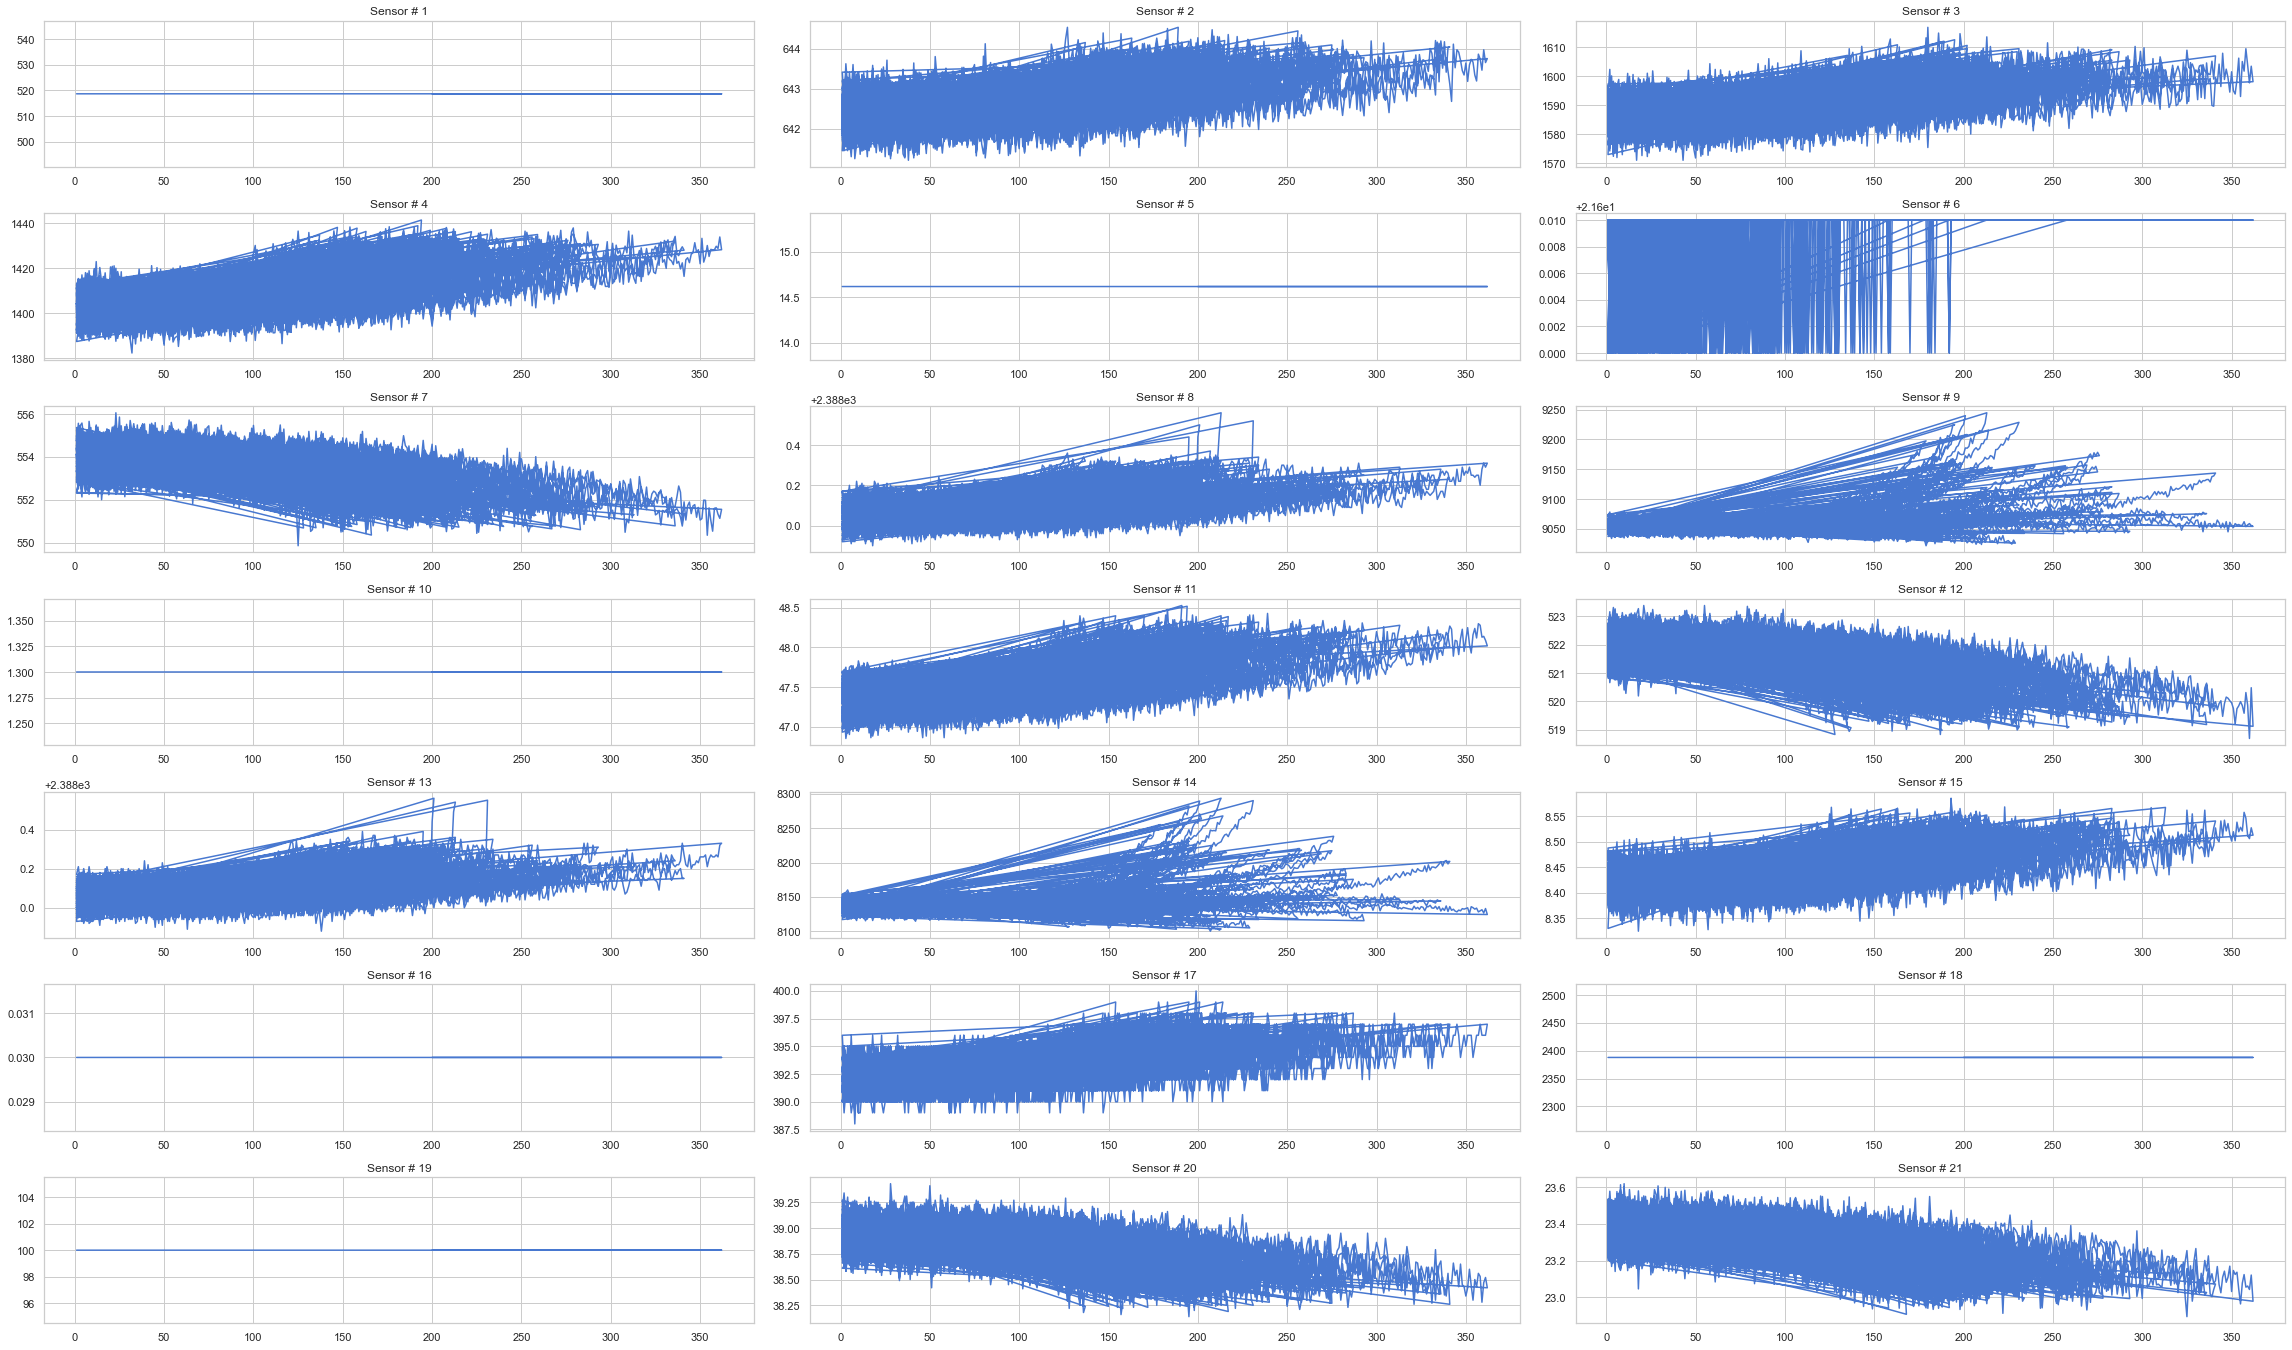

In [8]:
Graph_ALL_SensorData(df1)

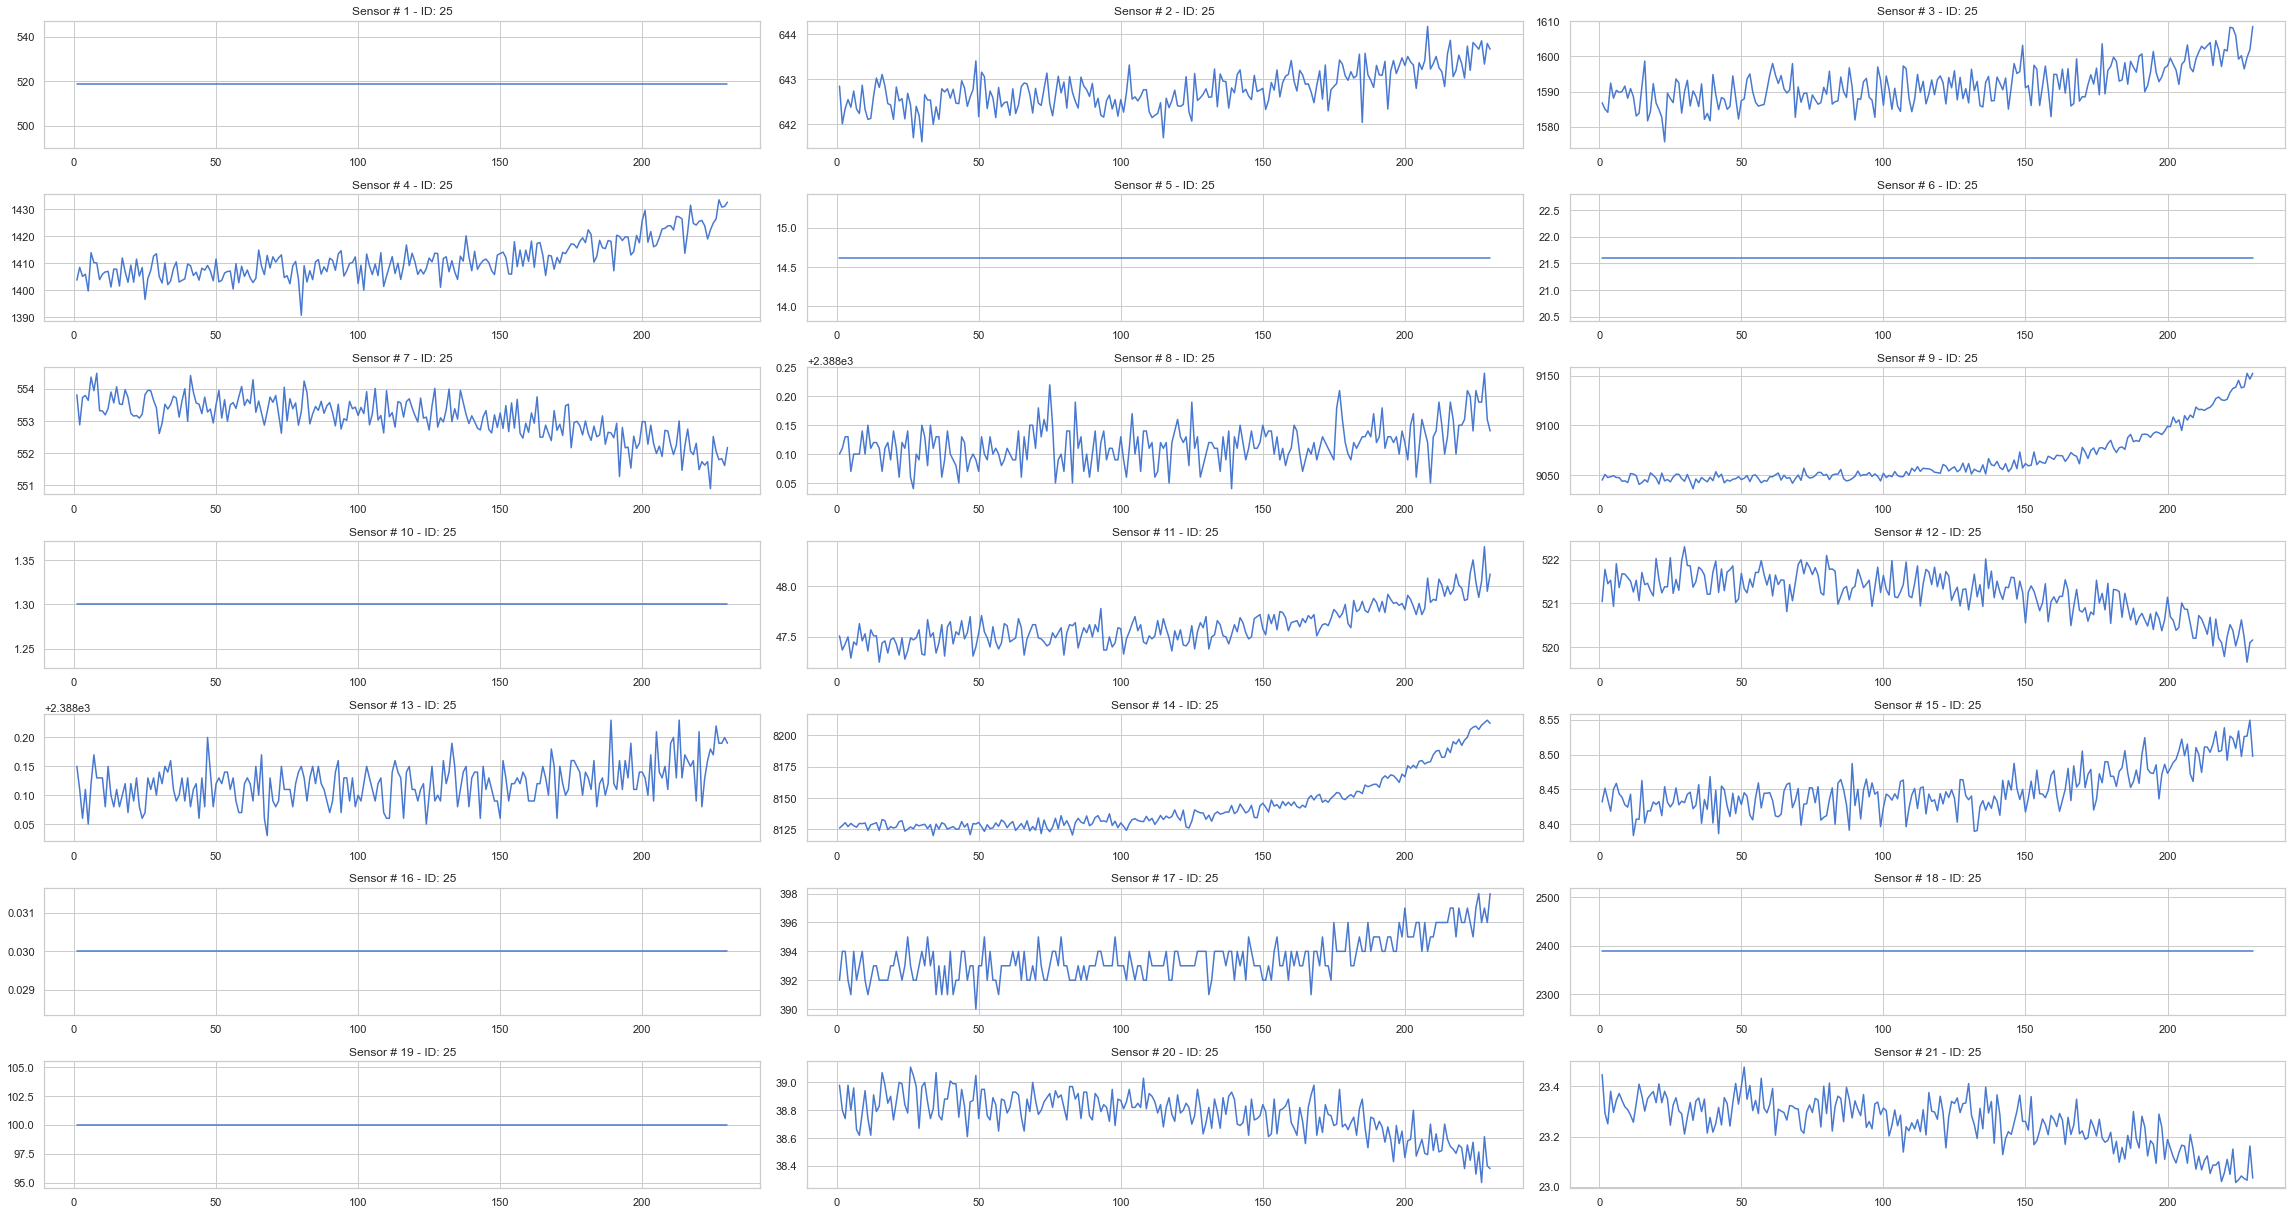

In [9]:
GraphSensorData(dataframe= df1, ID=25)

Here, it is observable that some sensors have null values throughout the dataset or that the values are erratic.


Now, I'm interested in know the correlation between the sensors. I build a heatmap of correlations.

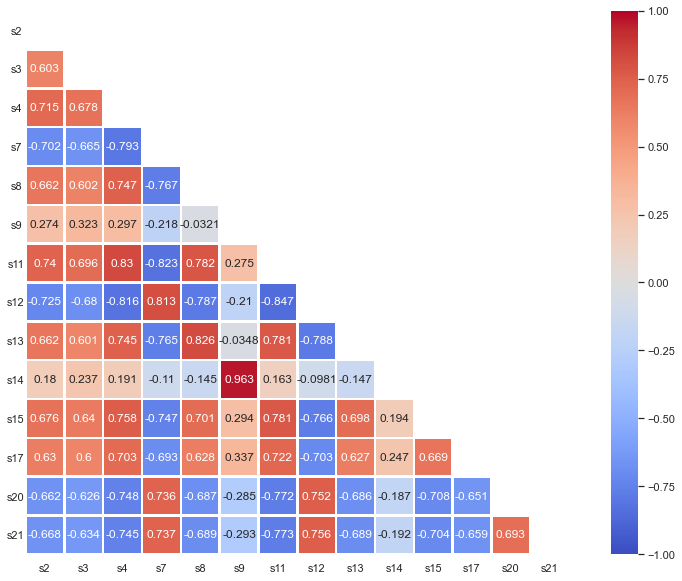

In [10]:
# https://heartbeat.fritz.ai/seaborn-heatmaps-13-ways-to-customize-correlation-matrix-visualizations-f1c49c816f07
Sensors_col = df1.filter(['s2','s3','s4','s7','s8','s9','s11','s12','s13','s14','s15','s17','s20','s21'])
corr = Sensors_col.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
matrix = np.triu(corr)
plt.figure(figsize=(15,10))

ax = sns.heatmap(
    corr, 
    vmin= -1, vmax=1, center=0,
    cmap= 'coolwarm',
    mask= matrix,
    square= True,
    annot= True,
    fmt= '.3g',
    linewidths=1.5, linecolor='white'
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    horizontalalignment='center'
);

ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,
    horizontalalignment='center'
);   

It is observable that Sensor 14 and 9 are highly correlated, so I consider removing one of them. To choose which one, I will use the following 2 blocks to confirm the correlation and choose the one with a correlation greater than 0.95

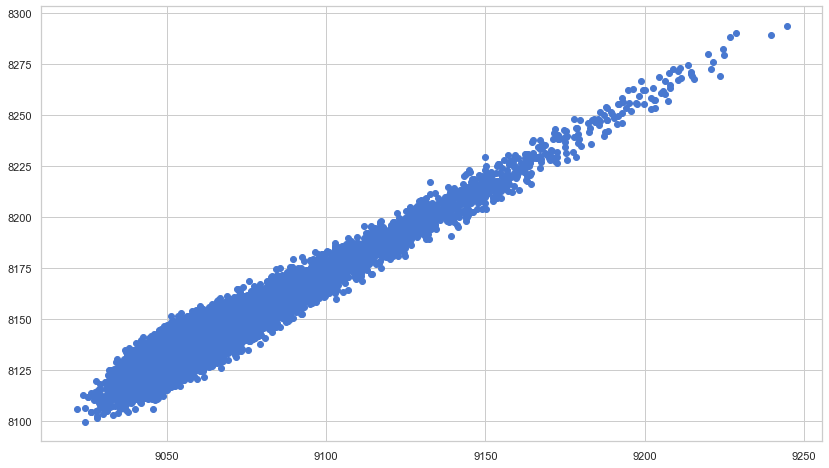

In [11]:
plt.scatter(df1['s9'].values, df1['s14'].values)

In [12]:
# Create correlation matrix
corr_matrix = Sensors_col.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] >= 0.95)]

# Drop features 
# df.drop(to_drop, axis=1, inplace=True)
to_drop

['s14']

I will plot the distributions of the sensors. I plot the mean in a red vertical line.

In [13]:
def GraphSensorsDistributions(dataframe):
    plt.figure(figsize=(20, 20))
    for i, name_col in enumerate(Sensors_col.columns):
        try:
            if(len(dataframe[name_col].unique())>1):
                mean = dataframe[name_col].mean()
                std = dataframe[name_col].std()
                title = f'Mean: {mean:.2f} | Std: {std:.2f}'
                plt.subplot(10, 3, i+1).set_title(title)
                sns.distplot(dataframe[name_col])
                plt.axvline(mean, c='red')
#                 plt.axvline(mean+std*3,c='r')
        except:
            pass
    plt.tight_layout()
    plt.show()

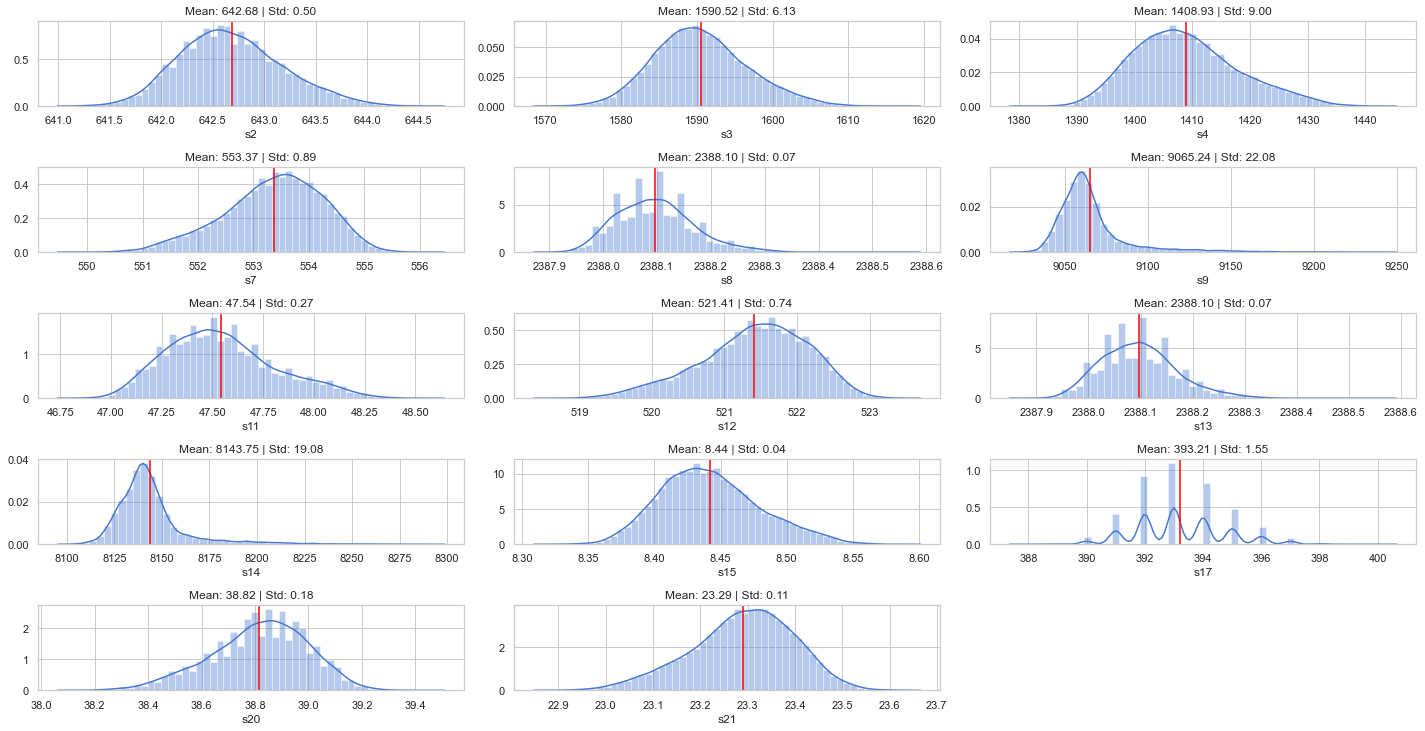

In [14]:
GraphSensorsDistributions(df1)

Finally, I drop the columns I previously discarded based on correlation and useless information or its quality.

In [15]:
df1.drop(['operational_setting_3','s1', 's5', 's6', 's10', 's14', 's16', 's18', 's19'], axis=1, inplace=True)
test_df1.drop(['operational_setting_3','s1', 's5', 's6', 's10', 's14', 's16', 's18', 's19'], axis=1, inplace=True)

Sensors_col = df1.filter(['s2','s3','s4','s7','s8','s9','s11','s12','s13','s15','s17','s20','s21'])

I want to know MAX, Mean, MIN values of RUL

In [16]:
max_cycles = np.array(df1.groupby(['ID'], axis=0)['cycle'].max())
print("Max RUL: ",max(max_cycles))
print("Mean RUL: ",np.mean(max_cycles))
print("Min RUL: ",min(max_cycles))

Max RUL:  362
Mean RUL:  206.31
Min RUL:  128


#### RULS Train

I arrange the values of RUL in a new columns in functions of the cycles of the test

In [17]:
groupedID = df1.groupby(['ID'], axis=0)
ID_Series = df1['ID'].unique()
RUL_df = pd.Series([j  for i in ID_Series for j in np.array(groupedID.get_group(i)[::-1]['cycle'])])

#### RULS Test

In [18]:
groupedID_test = test_df1.groupby(['ID'], axis=0)
ID_Series_test = test_df1['ID'].unique()
RUL_df_test = pd.Series([k for i in ID_Series_test for k in np.array(groupedID_test.get_group(i)[::-1]['cycle'])])

## Scale data

I standardize the data of sensors and operational settings.

In [19]:
from sklearn.preprocessing import StandardScaler

In [20]:
def Standardrize(df, scaler=None):
    
    if scaler == None:
        scaler = StandardScaler()
        scaler = scaler.fit(df)
    
    new_df = scaler.transform(df)

    return new_df, scaler

In [21]:
X = df1.drop(['ID', 'cycle'], axis=1) # Shape (20631, 15)
X_test = test_df1.drop(['ID', 'cycle'], axis=1) # Shape (13096, 15)

Y = np.array(RUL_df).reshape(-1,1) # Shape (20631, 1)
Y_test = np.array(RUL_df_test).reshape(-1,1) # Shape (13096, 1)

X_Std, X_Scaler = Standardrize(X)
X_test_Std, X_test_Scaler = Standardrize(X_test, scaler=X_Scaler)

X_Std_df = pd.DataFrame(X_Std, columns=X.columns)
X_Std_test_df = pd.DataFrame(X_test_Std, columns=X.columns)

In [22]:
print('Shape of X_std_df: ', X_Std_df.shape)
print('Shape of Y: ', Y.shape)

print('Shape of X_Std_test_df: ', X_Std_test_df.shape)
print('Shape of Y_test: ', Y_test.shape)

Shape of X_std_df:  (20631, 15)
Shape of Y:  (20631, 1)
Shape of X_Std_test_df:  (13096, 15)
Shape of Y_test:  (13096, 1)


In [23]:
X_Std_df['ID'] = df1['ID']
X_Std_df['RUL'] = Y

X_Std_test_df['ID'] = test_df1['ID']
X_Std_test_df['RUL'] = Y_test

I divide the whole dataset in a padded tensor. The objective it's transform it to the way that the LSTMs/GRUs can use/receive it.

In [24]:
# Function by https://www.kaggle.com/phamvanvung

import random
from keras.preprocessing.sequence import pad_sequences

def getPieceWiseData(data, augmentStartCycle=None, augmentEndCycle=None, movingAverage=None):
    uniqueIds = data['ID'].unique()
    
    if movingAverage==None:
        result = [data[data['ID']==mId].values for mId in uniqueIds]
    else:
        result = [data[data['ID']==mId].rolling(movingAverage).mean().dropna().values for mId in uniqueIds]
        
    maxlen = np.max([len(x) for x in result])
    
    if(augmentStartCycle!=None and augmentEndCycle!= None):
        result1 = []
        for mc in result:
            maxCycle = len(mc)
            for i in range(100):
                idx = random.randint(max([maxCycle-145, 10]), max([maxCycle-10, 10]))
                if(len(mc[:idx, :])>0):
                    result1.append(mc[:idx, :])
            #Also add the complete sequence.
#             result1.append(mc)
        result = result1

    ruls = [min(mc[:, -1]) for mc in result]
    return result,ruls, maxlen

def getPaddedSequence(data, pad_type='pre', maxlen=None, augmentStartCycle=None, augmentEndCycle=None, movingAverage=None):
    
    piece_wise, ruls, ml = getPieceWiseData(data, augmentStartCycle, augmentEndCycle, movingAverage)
    
    if(maxlen==None):
        maxlen = ml
        
    padded_sequence = pad_sequences(piece_wise, padding=pad_type, maxlen=maxlen, dtype='float32')
    
    return padded_sequence, ruls, maxlen

Using TensorFlow backend.


In [25]:
augmentStartCycle = 0 # 130
augmentEndCycle = 362
maxlen=None

padded_train, train_ruls, maxlen = getPaddedSequence(X_Std_df, maxlen=maxlen, augmentStartCycle=augmentStartCycle, augmentEndCycle=augmentEndCycle)
padded_test, _ , maxlen = getPaddedSequence(X_Std_test_df, maxlen=maxlen)

In [26]:
test_ruls = RUL_df1.values.tolist()

In [27]:
from tensorflow import slice

padded_train = np.array(slice(padded_train, [0, 0, 0], [padded_train.shape[0], padded_train.shape[1], padded_train.shape[2]-2])) # (5000, 362, 17) --> (5000, 362, 15)
padded_test = np.array(slice(padded_test, [0, 0, 0], [padded_test.shape[0], padded_test.shape[1], padded_test.shape[2]-2])) # (100, 362, 17) --> (100, 362, 15)

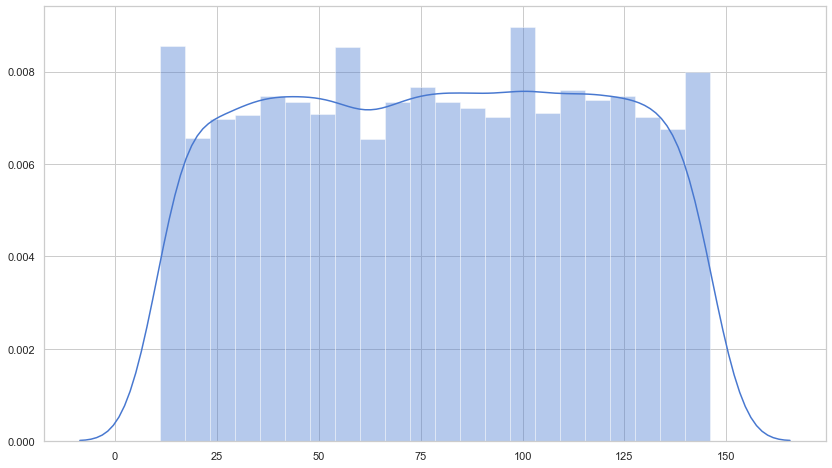

In [28]:
sns.distplot(train_ruls,norm_hist=True )
plt.show()

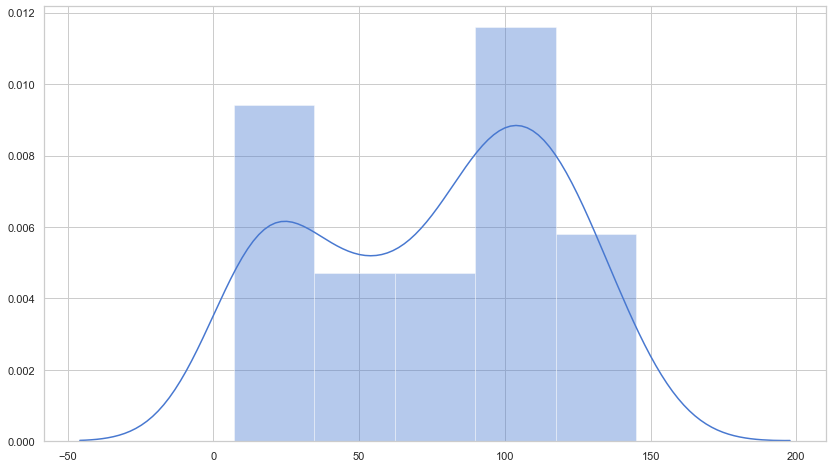

In [29]:
sns.distplot(test_ruls,norm_hist=True )
plt.show()

In [30]:
X_train = padded_train.copy() # (10000, 362, 15)
Y_train = np.array(train_ruls).reshape(-1,1) # (10000, 1)
numOfSensors = len(padded_train[0][0]) # 15

X_test = padded_test.copy() # (100, 362, 15)
Y_test = np.array(test_ruls).reshape(-1,1) # (100, 1)

## ML Architectures

I build 2 similar architectures: CNN-LSTM and CNN-GRU

### CNN-LSTM

In this case i build a CNN-LSTM using Convolutional, maxpooling, Dense, LSTM layers with Dropout and L2-regularization as regularizers. As activation funtion during convolutional and dense layer I decide to use 'selu' with a lecun normal weights initialization distribution for avoiding problems at training.

In [31]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Convolution1D, MaxPooling1D, Flatten, LSTM, GRU, Dense, Activation, Dropout, AlphaDropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2 
from sklearn.model_selection import StratifiedKFold

In [32]:
def createCNNLSTMModel(inputShape,
                       Optimizer='rmsprop',
                       Loss='mse'):
    
    cv1 = Convolution1D(input_shape=inputShape, filters=32, kernel_size=2, strides=1, padding='same', activation='selu', name='cv1')
    mp1 = MaxPooling1D(pool_size=2, strides=2, padding='same', name = 'mp1')
    
    cv2 = Convolution1D(filters=64, kernel_size=2, strides=1, padding='same', activation='selu', name='cv2')
    mp2 = MaxPooling1D(pool_size=2, strides=2, padding='same', name= 'mp2')
    
    cv3 = Convolution1D(filters=96, kernel_size=2, strides=1, padding='same', activation='selu', name='cv3')
    mp3 = MaxPooling1D(pool_size=2, strides=2, padding='same', name= 'mp3')
    
    d4 = Dense(inputShape[0]*inputShape[1], activation='selu', kernel_initializer = 'lecun_normal', kernel_regularizer= l2(0.01))
    dr1 = Dropout(0.2)
    
    lstm5 = LSTM(inputShape[1]*3, dropout=0.2, recurrent_regularizer=l2(0.01), return_sequences=True)
    
    lstm6 = LSTM(inputShape[1]*3, dropout=0.2, recurrent_regularizer=l2(0.01))
    
    d7 = Dense(50, activation='selu', kernel_initializer = 'lecun_normal', kernel_regularizer= l2(0.01))
    dr2 = Dropout(0.2)
    
    dout = Dense(1)
    
    model = Sequential([cv1, mp1, cv2, mp2, cv3, mp3, d4, dr1, lstm5, lstm6, d7, dr2, dout], name= 'LSTM_Model')
    model.compile(optimizer=Optimizer, loss=Loss)
    return model

In [33]:
model = createCNNLSTMModel((maxlen, numOfSensors))
model.summary()

Model: "LSTM_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cv1 (Conv1D)                 (None, 362, 32)           992       
_________________________________________________________________
mp1 (MaxPooling1D)           (None, 181, 32)           0         
_________________________________________________________________
cv2 (Conv1D)                 (None, 181, 64)           4160      
_________________________________________________________________
mp2 (MaxPooling1D)           (None, 91, 64)            0         
_________________________________________________________________
cv3 (Conv1D)                 (None, 91, 96)            12384     
_________________________________________________________________
mp3 (MaxPooling1D)           (None, 46, 96)            0         
_________________________________________________________________
dense (Dense)                (None, 46, 5430)          5

The objective is to train a LSTM network using k-fold in order to create and find iteratively a good model. I use Early Stopping to prevent overfitting (measuring MSE over the validation loss) 

In [34]:
# K-folds
kfold = StratifiedKFold(n_splits=3, shuffle=True)

LSTM_mse_scores = []
LSTM_History = []
counter= 1
Number = 1

for trainIdx, testIdx in kfold.split(X_train, Y_train):
    
    print(f"\n-------------->> STEP {counter} <<----------------\n")
    
    # create callbacks
    model_path = 'LSTM_Best_Model_set_'+str(Number)+'_fold'+str(counter)+'.h5'
    mc = ModelCheckpoint(model_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    es = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1)
    
    # create model
    model = createCNNLSTMModel((maxlen, numOfSensors), Optimizer='Adam')
    
    # Fit
    H = model.fit(X_train[trainIdx], Y_train[trainIdx],
                  validation_data=(X_train[testIdx], Y_train[testIdx]),
                  batch_size=32,
                  epochs=8,
                  callbacks=[mc, es])
    
    LSTM_History.append(H)
   
    # Done load the best model of this fold
    # Path
    print("\n Evaluate: \n")
    saved_model = load_model(model_path)
    LSTM_mse_scores.append({'path': model_path, 'mse': saved_model.evaluate(X_train[testIdx], Y_train[testIdx], verbose=2)})
    
    counter = counter + 1


-------------->> STEP 1 <<----------------

Train on 6666 samples, validate on 3334 samples
Epoch 1/8
6624/6666 [============================>.] - ETA: 0s - loss: 3001.1294
Epoch 00001: val_loss improved from inf to 698.68971, saving model to LSTM_Best_Model_set_1_fold1.h5
6666/6666 [==============================] - 19s 3ms/sample - loss: 2986.9018 - val_loss: 698.6897
Epoch 2/8
6624/6666 [============================>.] - ETA: 0s - loss: 666.9042
Epoch 00002: val_loss improved from 698.68971 to 551.34834, saving model to LSTM_Best_Model_set_1_fold1.h5
6666/6666 [==============================] - 8s 1ms/sample - loss: 666.5488 - val_loss: 551.3483
Epoch 3/8
6624/6666 [============================>.] - ETA: 0s - loss: 561.7739
Epoch 00003: val_loss improved from 551.34834 to 416.73915, saving model to LSTM_Best_Model_set_1_fold1.h5
6666/6666 [==============================] - 8s 1ms/sample - loss: 562.1872 - val_loss: 416.7391
Epoch 4/8
6624/6666 [============================>.] - ETA

In [35]:
for md in LSTM_mse_scores:
    saved_model = load_model(md['path'])
    print(md['path'])
    print(saved_model.evaluate(X_test, Y_test, verbose=2))

LSTM_Best_Model_set_1_fold1.h5
100/1 - 1s - loss: 219.5705
351.73934478759764
LSTM_Best_Model_set_1_fold2.h5
100/1 - 0s - loss: 278.5766
359.046337890625
LSTM_Best_Model_set_1_fold3.h5
100/1 - 1s - loss: 184.2159
284.08674896240234


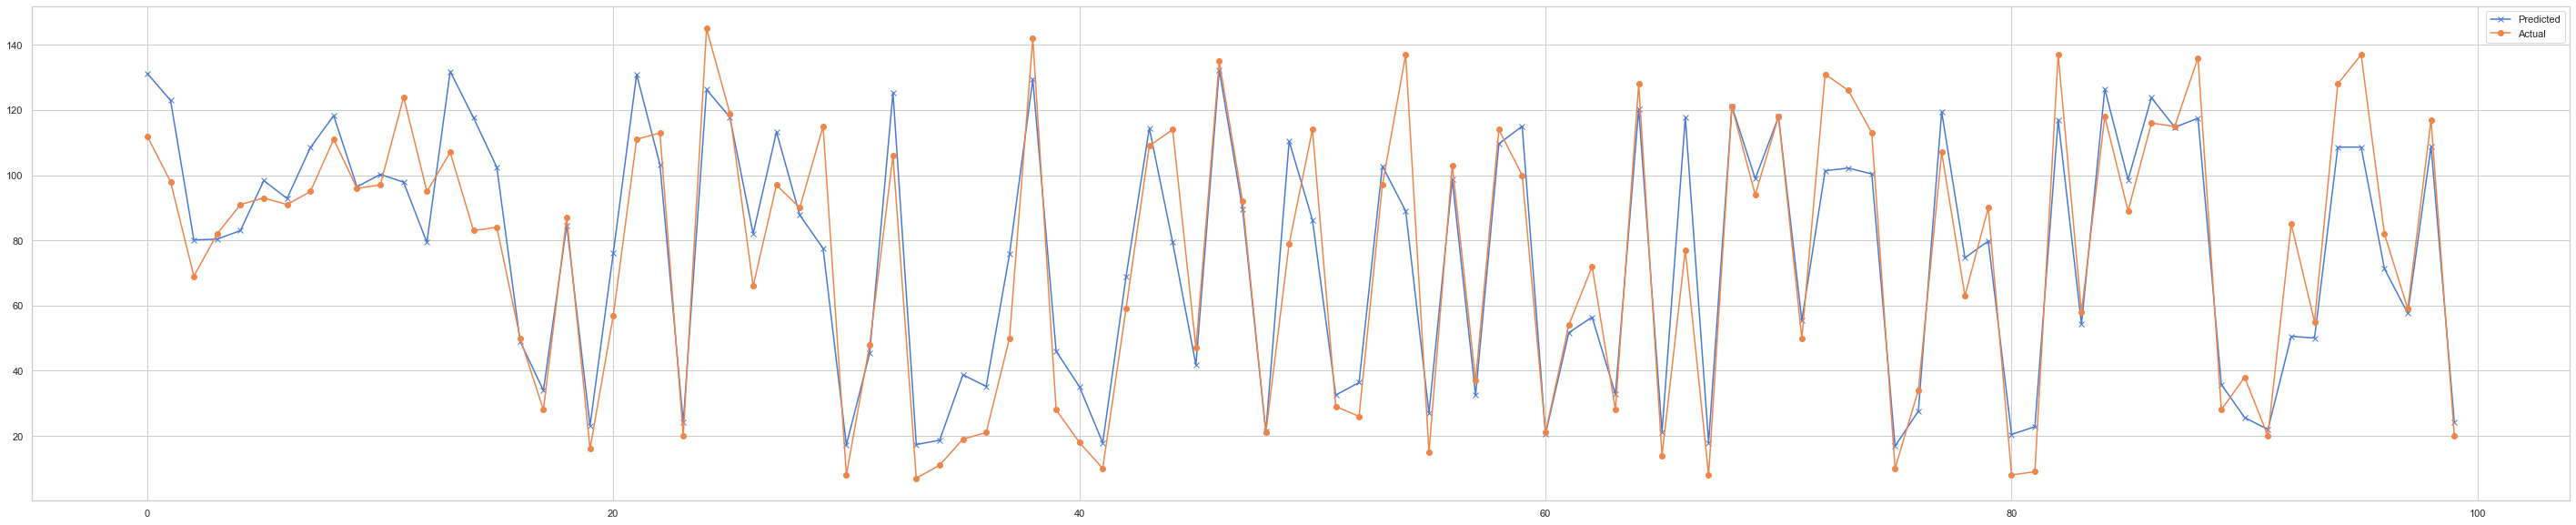

In [36]:
predicted = saved_model.predict(X_test)

plt.figure(figsize=(50, 10))
plt.plot(range(len(predicted)), predicted, '-x', label='Predicted')
plt.plot(range(len(Y_test)), Y_test, '-o', label='Actual')
plt.legend()
plt.show()

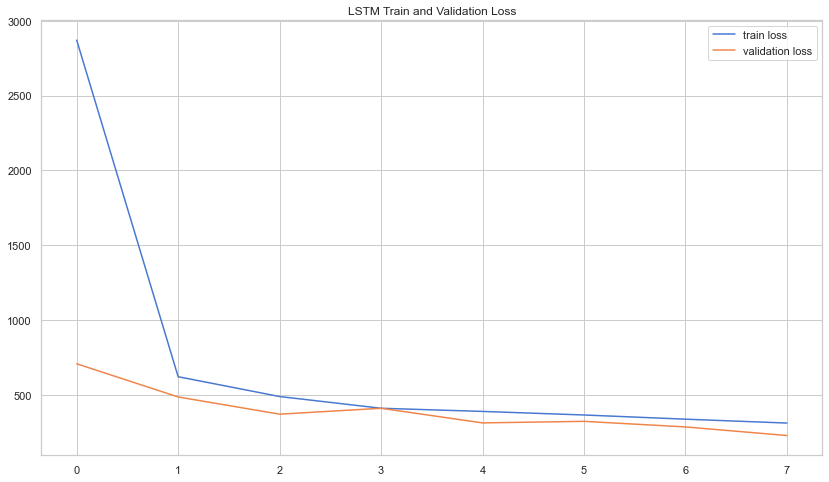

In [53]:
plt.title('LSTM Train and Validation Loss')
plt.plot(LSTM_History[2].history['loss'], label='train loss')
plt.plot(LSTM_History[2].history['val_loss'], label='validation loss')

plt.legend()
plt.show()
# plt.savefig('Train Loss_comparison_of_networks.png')

### PERFORMANCE EVALUATION

"Performance evaluation is concerned with employing metrics that help assess if the prognosis meets specifications for the task at hand. In PHM context, since the key aspect is to avoid failures, it is generally desirable to predict early as compared to predicting late. However, in specific situations where failures may not pose life threatening situations and early predictions may instead involve significant economic burden, this equation may change and one may not prefer conservative predictions. Hence, a performance evaluation system should reflect such characteristics to meet specific requirements.


For an engine degradation scenario an early prediction is preferred over late predictions. Therefore, the scoring algorithm for this challenge was asymmetric around the true time of failure such that late predictions were more heavily penalized than early predictions. In either case, the penalty grows exponentially with increasing error. The asymmetric preference is controlled by parameters a1 and a2 in the scoring function given below"

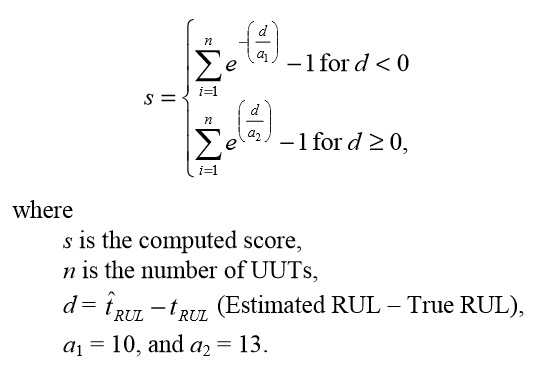

The Figure shows the score as a function of the error.

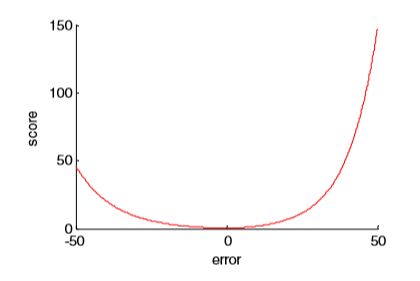

In [38]:
Evaluate_df = pd.DataFrame()
Evaluate_df['Estimated_RUL']=pd.Series(predicted.reshape(-1).tolist())
Evaluate_df['True_RUL']=pd.Series(Y_test.reshape(-1).tolist())
Evaluate_df.sample(3)

,Estimated_RUL,True_RUL
18,84.648293,87
72,101.371101,131
98,108.921684,117


In [39]:
Evaluate_df['Estimated_RUL'].to_csv('Predicted_RUL_LSTM.csv')

In [40]:
a1 = 10
a2 = 13
s = []
corr = Evaluate_df.corr()

for d in (predicted - Y_test):
    if d <0:
        ans = math.exp(-(d/a1))-1
        s.append(ans)
    else:
        ans = math.exp((d/a2))-1
        s.append(ans)

print('Score: ', sum(s))
print('Correlation: ', corr.iloc[1,0])

Score:  477.44844158434415
Correlation:  0.9255867093439542


### CNN-GRU

In this case i build a CNN-GRU using Convolutional, maxpooling, Dense, LSTM layers with Batch Normalization and L2-regularization as regularizers. As activation funtion during convolutional and dense layer I decide to use 'selu' with a lecun normal weights initialization distribution for avoiding problems at training.

In [41]:
def createCNNGRUModel(inputShape,
                       Optimizer='rmsprop',
                       Loss='mse'):
    
    cv1 = Convolution1D(input_shape=inputShape, filters=32, kernel_size=2, strides=1, padding='same', activation='selu', name='cv1')
    mp1 = MaxPooling1D(pool_size=2, strides=2, padding='same', name = 'mp1')
    
    cv2 = Convolution1D(filters=64, kernel_size=2, strides=1, padding='same', activation='selu', name='cv2')
    mp2 = MaxPooling1D(pool_size=2, strides=2, padding='same', name= 'mp2')
    
    cv3 = Convolution1D(filters=96, kernel_size=2, strides=1, padding='same', activation='selu', name='cv3')
    mp3 = MaxPooling1D(pool_size=2, strides=2, padding='same', name= 'mp3')
    
    d4 = Dense(inputShape[0]*inputShape[1], activation='selu', kernel_initializer = 'lecun_normal', kernel_regularizer= l2(0.01))
    bn1 = BatchNormalization()
    
    lstm5 = GRU(inputShape[1]*3, dropout=0.2, recurrent_regularizer=l2(0.01), return_sequences=True)
    
    lstm6 = GRU(inputShape[1]*3, dropout=0.2, recurrent_regularizer=l2(0.01))
    
    d7 = Dense(50, activation='selu', kernel_initializer = 'lecun_normal', kernel_regularizer= l2(0.01))
    bn2 = BatchNormalization()
#     dr = Dropout(0.2)
    
    dout = Dense(1)
    
    model = Sequential([cv1, mp1, cv2, mp2, cv3, mp3, d4, bn1, lstm5, lstm6, d7, bn2, dout], name= 'GRU_Model')
    model.compile(optimizer=Optimizer, loss=Loss)
    return model

In [42]:
model = createCNNGRUModel((maxlen, numOfSensors))
model.summary()

Model: "GRU_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cv1 (Conv1D)                 (None, 362, 32)           992       
_________________________________________________________________
mp1 (MaxPooling1D)           (None, 181, 32)           0         
_________________________________________________________________
cv2 (Conv1D)                 (None, 181, 64)           4160      
_________________________________________________________________
mp2 (MaxPooling1D)           (None, 91, 64)            0         
_________________________________________________________________
cv3 (Conv1D)                 (None, 91, 96)            12384     
_________________________________________________________________
mp3 (MaxPooling1D)           (None, 46, 96)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 46, 5430)          52

The objective is to train a GRU network using k-fold in order to create and find iteratively a good model. I use Early Stopping to prevent overfitting (measuring MSE over the validation loss) 

In [43]:
# K-folds
kfold = StratifiedKFold(n_splits=3, shuffle=True)

GRU_mse_scores = []
GRU_History = []
counter= 1
Number = 1

for trainIdx, testIdx in kfold.split(X_train, Y_train):
    
    print(f"\n-------------->> STEP {counter} <<----------------\n")
    
    # create callbacks
    model_path = 'GRU_Best_Model_set_'+str(Number)+'_fold'+str(counter)+'.h5'
    mc = ModelCheckpoint(model_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    es = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1)
    
    # create model
    model = createCNNGRUModel((maxlen, numOfSensors), Optimizer='Adam')
    
    # Fit
    H = model.fit(X_train[trainIdx], 
                  Y_train[trainIdx],
              validation_data=(X_train[testIdx], Y_train[testIdx]),
              batch_size=32,
              epochs=8,
              callbacks=[mc, es])
    
    GRU_History.append(H)
   
    # Done load the best model of this fold
    print("\n Evaluate: \n")
    saved_model = load_model(model_path)
    GRU_mse_scores.append({'path': model_path, 'mse': saved_model.evaluate(X_train[testIdx], Y_train[testIdx], verbose=2)})
    
    counter = counter + 1


-------------->> STEP 1 <<----------------

Train on 6666 samples, validate on 3334 samples
Epoch 1/8
6624/6666 [============================>.] - ETA: 0s - loss: 6786.9529
Epoch 00001: val_loss improved from inf to 5552.62380, saving model to GRU_Best_Model_set_1_fold1.h5
6666/6666 [==============================] - 13s 2ms/sample - loss: 6777.7992 - val_loss: 5552.6238
Epoch 2/8
6624/6666 [============================>.] - ETA: 0s - loss: 5137.7122 ETA: 0s - loss: - ETA: 0s - l
Epoch 00002: val_loss improved from 5552.62380 to 3903.80115, saving model to GRU_Best_Model_set_1_fold1.h5
6666/6666 [==============================] - 8s 1ms/sample - loss: 5127.4646 - val_loss: 3903.8012
Epoch 3/8
6624/6666 [============================>.] - ETA: 0s - loss: 3339.5573 ETA: 1s - loss: 3592. - ETA: 1s - ETA - ETA: 0s - loss: 3
Epoch 00003: val_loss improved from 3903.80115 to 2110.42002, saving model to GRU_Best_Model_set_1_fold1.h5
6666/6666 [==============================] - 8s 1ms/sample -

### Evaluate on Test

In [44]:
for md in GRU_mse_scores:
    saved_model = load_model(md['path'])
    print(md['path'])
    print(saved_model.evaluate(X_test, Y_test, verbose=2))

GRU_Best_Model_set_1_fold1.h5
100/1 - 1s - loss: 219.7925
351.74193481445315
GRU_Best_Model_set_1_fold2.h5
100/1 - 1s - loss: 218.1533
305.24787963867186
GRU_Best_Model_set_1_fold3.h5
100/1 - 1s - loss: 395.9058
433.20253295898436


#### Predict

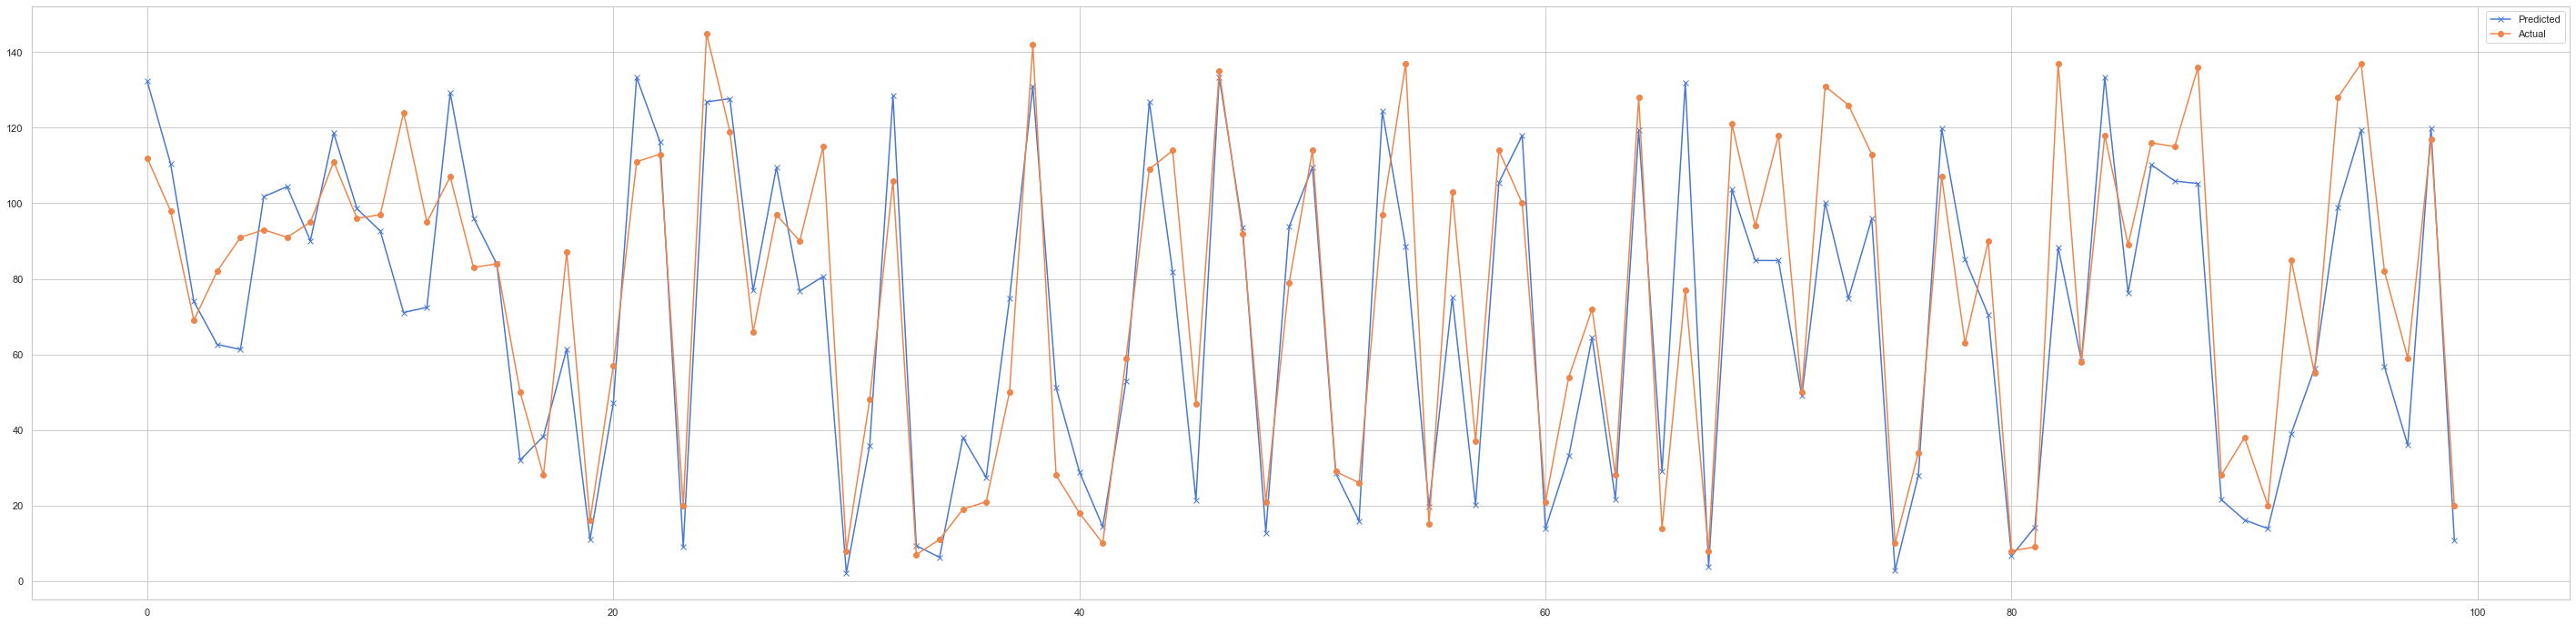

In [45]:
predicted = saved_model.predict(X_test)

plt.figure(figsize=(50, 12))
plt.plot(range(len(predicted)), predicted, '-x', label='Predicted')
plt.plot(range(len(Y_test)), Y_test, '-o', label='Actual')
plt.legend()
plt.show()

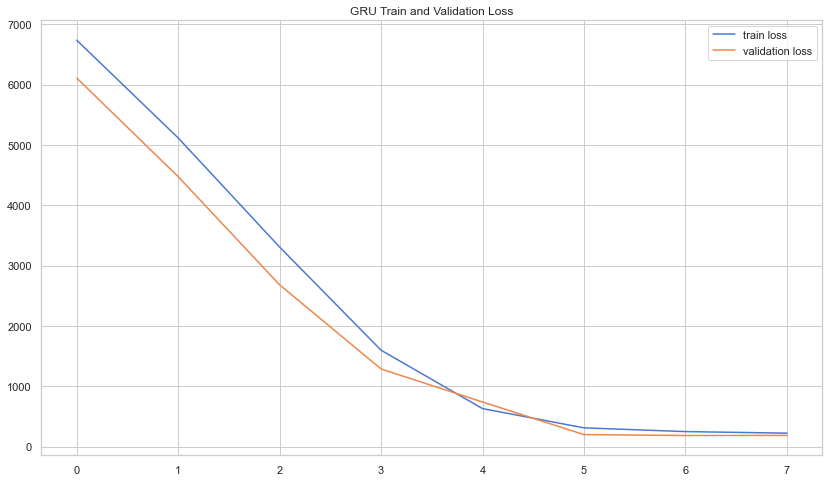

In [52]:
plt.title('GRU Train and Validation Loss')
plt.plot(GRU_History[1].history['loss'], label='train loss')
plt.plot(GRU_History[1].history['val_loss'], label='validation loss')

plt.legend()
plt.show()
# plt.savefig('Train Loss_comparison_of_networks.png')

In [46]:
Evaluate_df = pd.DataFrame()
Evaluate_df['Estimated_RUL']=pd.Series(predicted.reshape(-1).tolist())
Evaluate_df['True_RUL']=pd.Series(Y_test.reshape(-1).tolist())
Evaluate_df.sample(3)

,Estimated_RUL,True_RUL
89,21.505919,28
6,104.390190,91
43,126.874069,109


In [47]:
Evaluate_df['Estimated_RUL'].to_csv('Predicted_RUL_GRU.csv')

In [48]:
a1 = 10
a2 = 13
s = []
corr = Evaluate_df.corr()

for d in (predicted - Y_test):
    if d <0:
        ans = math.exp(-(d/a1))-1
        s.append(ans)
    else:
        ans = math.exp((d/a2))-1
        s.append(ans)

print('Score: ', sum(s))
print('Correlation: ', corr.iloc[1,0])

Score:  1176.9988465447343
Correlation:  0.8945785037805958


### References - Sitography

- Reference: A. Saxena, K. Goebel, D. Simon, and N. Eklund, “Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation”, in the Proceedings of the Ist International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008.
- http://www.phmsociety.org/sites/phmsociety.org/files/phm_submission/2014/ijphm_14_014.pdf
- https://www.reddit.com/r/MachineLearning/comments/67gonq/d_batch_normalization_before_or_after_relu/
- https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/
- https://keras.io/examples/reuters_mlp_relu_vs_selu/
- https://medium.com/@sakeshpusuluri123/activation-functions-and-weight-initialization-in-deep-learning-ebc326e62a5c
- https://medium.com/usf-msds/deep-learning-best-practices-1-weight-initialization-14e5c0295b94
- https://www.machinecurve.com/index.php/2019/09/16/he-xavier-initialization-activation-functions-choose-wisely/
- https://www.analyticsvidhya.com/blog/2017/10/fundamentals-deep-learning-activation-functions-when-to-use-them/
- https://keras.io/layers/advanced-activations/
- https://mlfromscratch.com/activation-functions-explained/#/
- https://stackoverflow.com/questions/48828478/how-do-you-use-keras-leakyrelu-in-python
- https://www.machinecurve.com/index.php/2019/11/12/using-leaky-relu-with-keras/
- https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/
- https://youtu.be/Xogn6veSyxA?t=1137
- https://machinelearningmastery.com/make-predictions-long-short-term-memory-models-keras/
- https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf
- https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction/home/week/2